# Menu Detection Lab

This notebook mirrors the pipeline setup used in `testing/pipeline/main.py`, but lets you iterate on menu-detection heuristics interactively. Run the setup cells, tweak `notebook_menu_detection`, and call `run_menu_detection` to visualize your results.


In [1]:
from pathlib import Path
import sys

NOTEBOOK_ROOT = Path.cwd().resolve()
PIPELINE_DIR = NOTEBOOK_ROOT

if PIPELINE_DIR.name != "pipeline" or not (PIPELINE_DIR / "main.py").exists():
    candidate = NOTEBOOK_ROOT / "testing" / "pipeline"
    if candidate.exists() and (candidate / "main.py").exists():
        PIPELINE_DIR = candidate

if not (PIPELINE_DIR / "main.py").exists():
    raise RuntimeError("Could not locate the testing/pipeline directory from the current working directory.")

PROJECT_ROOT = PIPELINE_DIR.parent.parent
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PIPELINE_DIR, PROJECT_ROOT


(PosixPath('/Users/mattcarroll/code/memoir/testing/pipeline'),
 PosixPath('/Users/mattcarroll/code/memoir'))

In [8]:
import json
import time
from typing import Any, Callable, Dict, Tuple

import numpy as np
from IPython.display import display
from PIL import Image

from utils import iter_image_paths, load_and_resize_image
from ocr_processing import init_ocr, run_ocr
from layout_analysis import filter_chrome, split_columns_dynamic, group_paragraphs
from visualization import (
    draw_menu_stage,
    draw_divider_edges,
    draw_ocr_boxes,
    create_combined_output,
)
from menu_detection import detect_menus as pipeline_detect_menus

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
INPUT_DIR = (PIPELINE_DIR.parent / "test_images").resolve()
OUTPUT_DIR = (PIPELINE_DIR / "out").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

REUSE_OCR = True

IMAGE_PATHS = list(iter_image_paths([INPUT_DIR]))
print(f"Found {len(IMAGE_PATHS)} images in {INPUT_DIR}")
for idx, path in enumerate(IMAGE_PATHS[:10]):
    print(f"{idx}: {path.name}")


Found 8 images in /Users/mattcarroll/code/memoir/testing/test_images
0: 20251021_121038_074_Messages_Emma❤️.png
1: 20251021_122152_434_Google_Chrome_Parks_&_Rec_but_all_the_Women_WANT_Ron_|_Parks_and.png
2: 20251021_122201_427_Google_Chrome_.png
3: 20251021_122207_874_Cursor_window.py_—_memoir.png
4: 20251021_123325_226_Spotify_Taylor_Swift_-_The_Fate_of_Ophelia.png
5: 20251021_123347_715_Calendar_Calendar.png
6: 20251021_123402_780_Google_Chrome_.png
7: 20251021_123404_238_Google_Chrome_Matt_Carroll.png


In [4]:
_OCR_MODEL = None
STATE_CACHE: Dict[Tuple[str, bool], Dict[str, Any]] = {}

def get_ocr_model():
    global _OCR_MODEL
    if _OCR_MODEL is None:
        print("Loading PaddleOCR model...")
        _OCR_MODEL = init_ocr()
        print("Model ready.")
    return _OCR_MODEL

def prepare_state(image_path, reuse_ocr=REUSE_OCR, output_dir=OUTPUT_DIR):
    image_path = Path(image_path).resolve()
    cache_key = (str(image_path), bool(reuse_ocr))
    if cache_key in STATE_CACHE:
        return STATE_CACHE[cache_key]

    image_output_dir = output_dir / image_path.stem
    image_output_dir.mkdir(parents=True, exist_ok=True)
    ocr_json_path = image_output_dir / "ocr.json"

    image_bgr, image_rgb, original_rgb, original_size, resized_size, scale = load_and_resize_image(image_path)

    boxes: list = []
    texts: list = []
    scores: list = []
    ocr_source = "fresh"

    if reuse_ocr and ocr_json_path.exists():
        try:
            with ocr_json_path.open("r", encoding="utf-8") as fp:
                cached = json.load(fp)
            boxes = cached.get("boxes") or []
            texts = cached.get("texts") or []
            scores = cached.get("scores") or []
            if len(texts) < len(boxes):
                texts.extend([""] * (len(boxes) - len(texts)))
            if len(scores) < len(boxes):
                scores.extend([None] * (len(boxes) - len(scores)))
            ocr_source = "cache"
        except json.JSONDecodeError:
            print(f"Cached OCR in {ocr_json_path} could not be parsed; rerunning OCR.")
        except Exception as exc:
            print(f"Failed to read cached OCR ({exc}); rerunning OCR.")

    if not boxes:
        model = get_ocr_model()
        boxes, texts, scores = run_ocr(model, image_bgr)
        with ocr_json_path.open("w", encoding="utf-8") as fp:
            json.dump({"boxes": boxes, "texts": texts, "scores": scores}, fp, indent=2)

    height, width = image_rgb.shape[:2]
    keep_indices, drop_indices = filter_chrome(
        image_rgb,
        boxes,
        texts,
        scores,
        left_ratio=0.12,
        top_ratio=0.06,
        min_conf=0.65,
    )

    columns = split_columns_dynamic(list(range(len(boxes))), boxes, width, eps_ratio=0.06, min_points=4)
    groups = []
    for col in columns:
        groups.extend(group_paragraphs(col, boxes, gap_factor=1.5))

    state = {
        "image_path": image_path,
        "image_rgb": image_rgb,
        "image_bgr": image_bgr,
        "boxes": boxes,
        "texts": texts,
        "scores": scores,
        "groups": groups,
        "drop_indices": drop_indices,
        "image_output_dir": image_output_dir,
        "meta": {
            "original_size": original_size,
            "resized_size": resized_size,
            "scale": scale,
            "ocr_source": ocr_source,
        },
    }

    STATE_CACHE[cache_key] = state
    return state


def run_menu_detection(menu_fn: Callable[[np.ndarray, list, list], list], image_index: int = 0, save_debug: bool = False, tag: str = "notebook"):
    if not IMAGE_PATHS:
        raise RuntimeError("No images available; check INPUT_DIR.")
    image_path = IMAGE_PATHS[image_index]
    state = prepare_state(image_path)

    menu_results = menu_fn(state["image_rgb"], state["boxes"], state["texts"])
    if menu_results is None:
        raise ValueError("menu_fn returned None; expected a list of region dictionaries.")

    print(f"Image: {image_path.name}")
    print(f"OCR source: {state['meta']['ocr_source']} | boxes: {len(state['boxes'])}")
    try:
        display(draw_menu_stage(state["image_rgb"], menu_results, stage="final"))
    except Exception as exc:
        print(f"draw_menu_stage failed: {exc}")
    try:
        display(draw_divider_edges(state["image_rgb"], state["boxes"], menu_results))
    except Exception as exc:
        print(f"draw_divider_edges failed: {exc}")
    try:
        display(create_combined_output(state["image_rgb"], state["boxes"], state["texts"], state["scores"], state["groups"], state["drop_indices"], menu_results))
    except Exception as exc:
        print(f"create_combined_output failed: {exc}")

    if save_debug:
        dest = state["image_output_dir"] / tag
        dest.mkdir(parents=True, exist_ok=True)
        try:
            draw_menu_stage(state["image_rgb"], menu_results, stage="final").save(dest / "menus_final.png")
        except Exception as exc:
            print(f"Failed to save menus_final.png: {exc}")
        try:
            draw_divider_edges(state["image_rgb"], state["boxes"], menu_results).save(dest / "dividers.png")
        except Exception as exc:
            print(f"Failed to save dividers.png: {exc}")
        try:
            create_combined_output(state["image_rgb"], state["boxes"], state["texts"], state["scores"], state["groups"], state["drop_indices"], menu_results).save(dest / "combined.png")
        except Exception as exc:
            print(f"Failed to save combined.png: {exc}")
        else:
            print(f"Saved debug outputs to {dest}")
    return state, menu_results


In [5]:
def notebook_menu_detection(image_rgb, boxes, texts):
    """Customize this function to experiment with new menu-detection logic."""
    return pipeline_detect_menus(image_rgb, boxes, texts)


Image: 20251021_121038_074_Messages_Emma❤️.png
OCR source: cache | boxes: 91


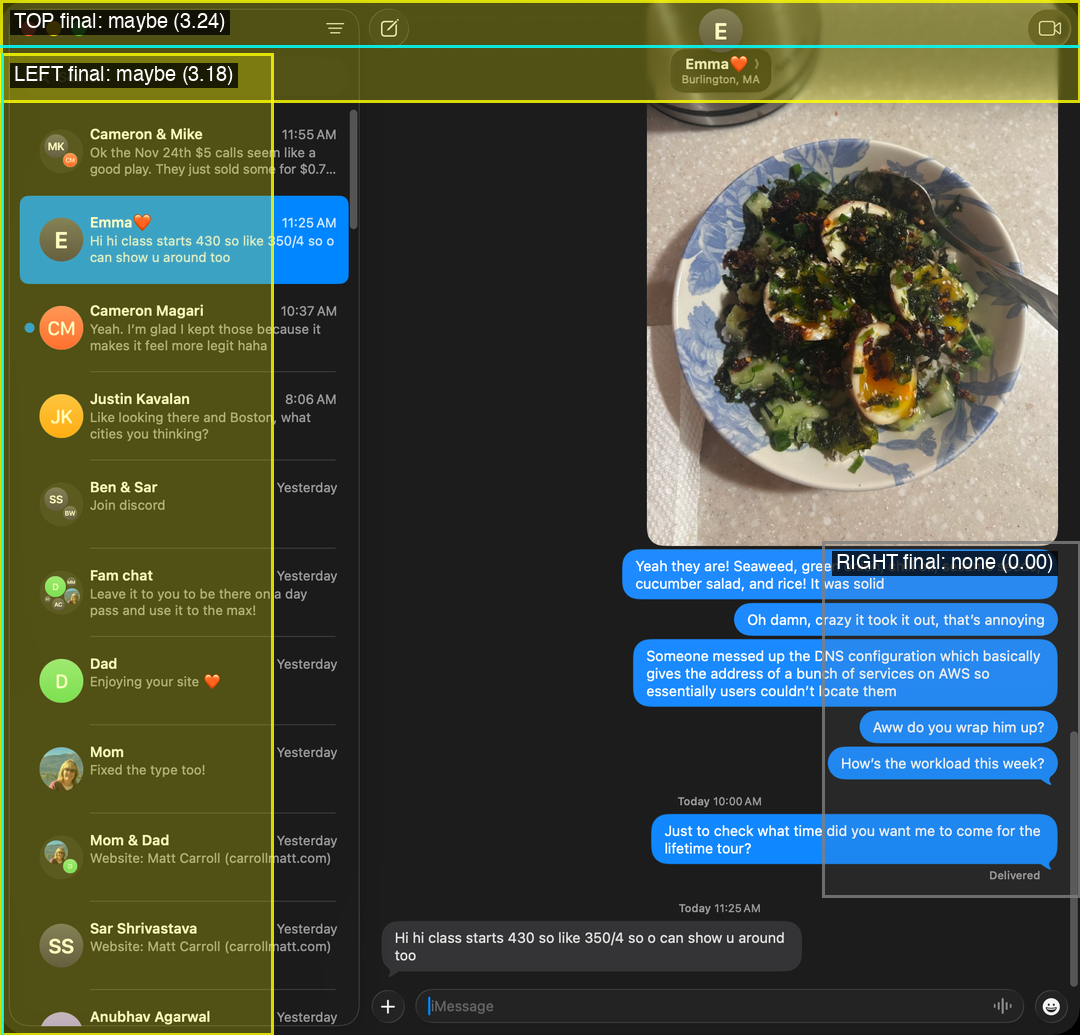

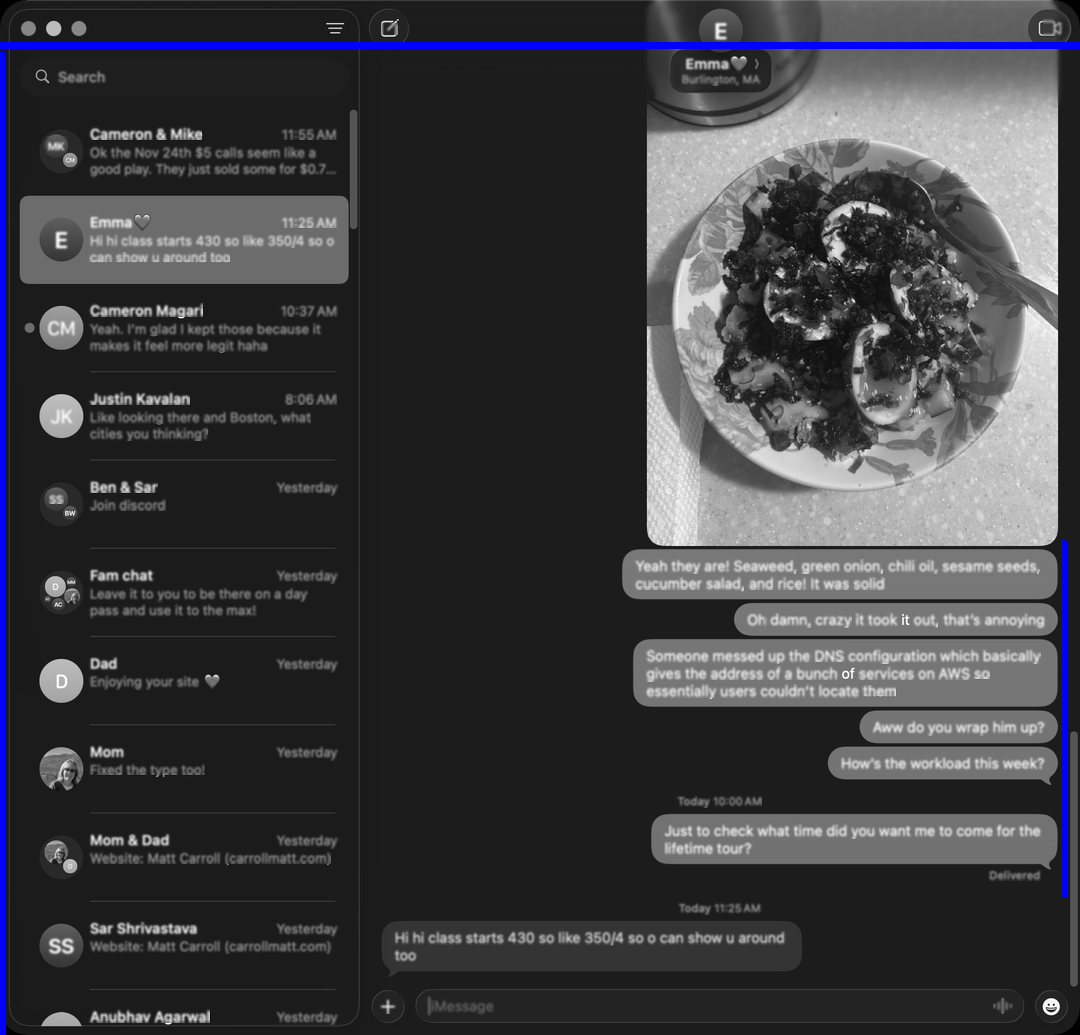

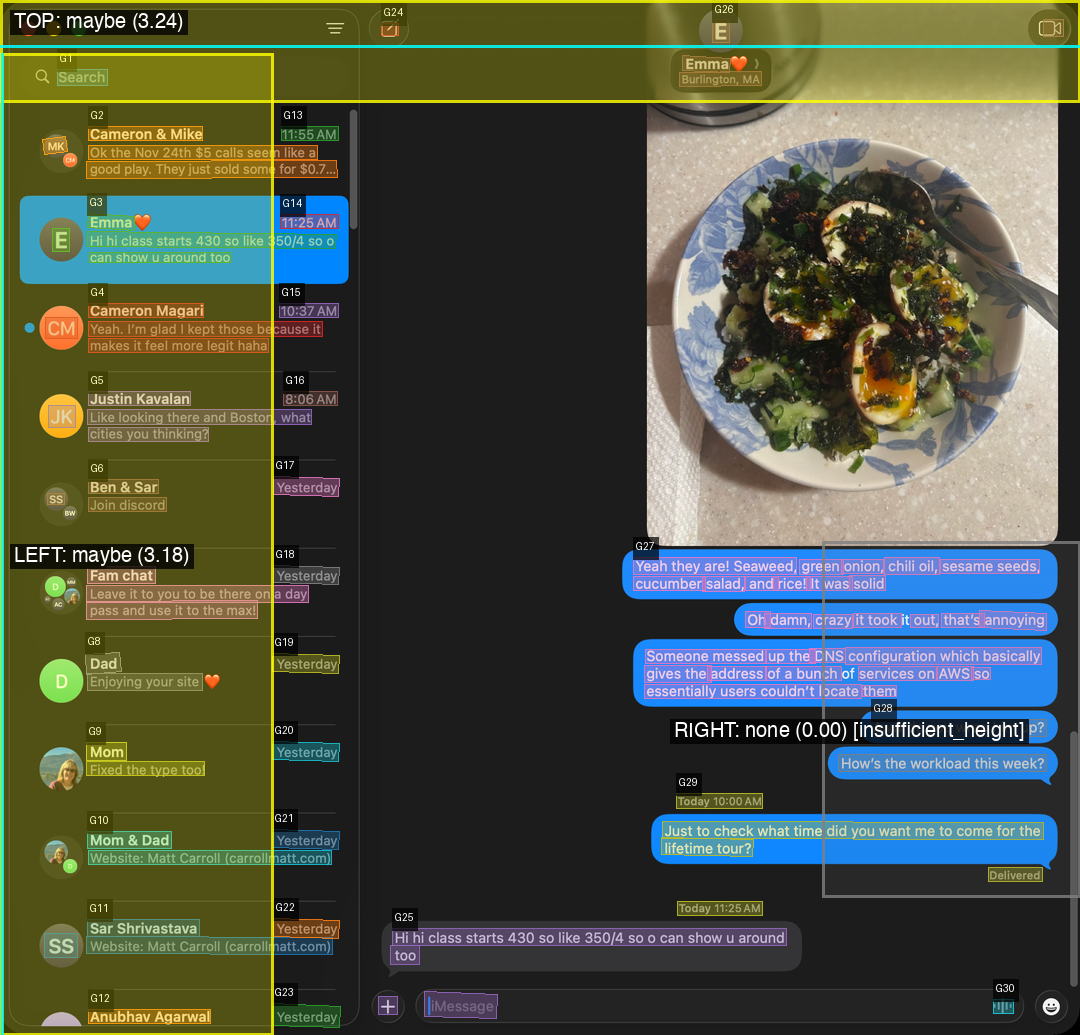

In [6]:
_ = run_menu_detection(notebook_menu_detection, image_index=0, save_debug=False)
